In [1]:
import pandas as pd
import matplotlib.pyplot as plt


### Magyarország legkeresettebb bűnözői

A rendőrség, a hivatalos oldalán nyilvánosan elérhetővé teszi a körözési adatbázisukban található személyek listáját.
A körözési toplista felületen azok a bűnelkövetők szerepelnek, akiket elfogatóparancs alapján keresnek.

A körözési toplistára kerülésnek feltételeit rendőrségi határozat szabályozza. Az elfogatóparancs a körözéssel szemben már azt is magába foglalja, hogy a személy büntetőügy gyanúsítottja, vagy szabadságvesztésre ítélték.

Az elkövetők adatlapján a személyes adatok mellett szerepel a bűncselekmény ami miatt körözik, illetve jelzik, hogy különösen veszélyes, esetleg fegyverrel rendelkezik.

Az elemzéshez használt adatokat web-scraping segítségével töltöttem le a rendőrség felületéről. https://www.police.hu/hu/koral/toplistas-korozesek
Az adatok 2023.március közepén aktuális státuszt prezentálják.






In [2]:
df = pd.read_csv("Korozesi_toplista.csv", sep = ";")
df.head()

,Nev,Nem,Szuletesi hely,Szuletesi datum,Allampolgarsag,Korozes,Nyomravezetoi dij,Jelzo
0,BÓDI VIKTOR,Férfi,DEBRECEN,1983-10-27,MAGYAR,KÁBÍTÓSZER-KERESKEDELEM,0,NaN
1,BÁNÁTI ATTILA,Férfi,VÁC,1980-01-18,MAGYAR,VISSZAÉLÉS KÁBÍTÓSZERREL,0,NaN
2,BÁNÁTI ATTILA,Férfi,VÁC,1980-01-18,MAGYAR,KÁBÍTÓSZER-KERESKEDELEM,0,NaN
3,BARKÓCZI TAMÁS,Férfi,TISZAFÜRED,1988-07-27,MAGYAR,RABLÁS,0,NaN
4,BARTOS NÁNDOR,Férfi,BAJA,1982-08-14,MAGYAR,EMBERCSEMPÉSZÉS,500000,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nev                77 non-null     object
 1   Nem                77 non-null     object
 2   Szuletesi hely     77 non-null     object
 3   Szuletesi datum    77 non-null     object
 4   Allampolgarsag     77 non-null     object
 5   Korozes            73 non-null     object
 6   Nyomravezetoi dij  77 non-null     int64 
 7   Jelzo              4 non-null      object
dtypes: int64(1), object(7)
memory usage: 4.9+ KB


### Adatok előkészítése

#### Adattisztítás

A web-scraping során nem foglalkoztam adattisztítással, így elképzelhető, hogy vannak felesleges szóközök a sztringek körül.

A Név oszlopot vizsgálom át ebből a szempontból, és ha ott találok felesleges szóközöket, akkor a Dataframe összes többi sztring típusú oszlopára is alkalmazom azt a metódust, ami az eltávolításukat végzi.

In [4]:
df["Nev"].to_list()[0:2]

[' BÓDI VIKTOR ', ' BÁNÁTI ATTILA ']

Az adathalmazról kapott információ alapján a Körözés és Jelző oszlop tartalmaz NaN értékeket, ezek miatt nem tudom eltávolítani egyszerre a felesleges szóközöket a Dataframe sztring típusú oszlopaiból. <br>
Első lépésként így az NaN értékkel foglalkozom.<br>
 - A Jelző oszlop null értékeit üres értékkel töltöm fel, hiszen azokra a személyekre nem vonatkoznak jelzők. <br>
 - A Körözés oszlopnak csak 4 sorából hiányzik érték, ezekre konkrétan rákeresek.


In [5]:
df["Jelzo"] = df["Jelzo"].fillna("")


In [6]:
df[df["Korozes"].isnull()]

,Nev,Nem,Szuletesi hely,Szuletesi datum,Allampolgarsag,Korozes,Nyomravezetoi dij,Jelzo
35,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,NaN,0,Különösen veszélyes
36,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,NaN,0,Fegyveres
57,SÜTŐ FERENC,Férfi,BUDAPEST 03,1979-11-27,MAGYAR,NaN,0,Különösen veszélyes
58,SÜTŐ FERENC,Férfi,BUDAPEST 03,1979-11-27,MAGYAR,NaN,0,Fegyveres


A körözés oka minden személy adatlapján fel van tüntetve. Ahhoz, hogy kiderüljön miért hiányzik bizonyos sorokban a bűncselekmény, az egyik érintett nevére szűrök.

In [7]:
# felesleges szóközök miatt részleges egyezőség

df[df["Nev"].str.contains("KOZÁK")]

,Nev,Nem,Szuletesi hely,Szuletesi datum,Allampolgarsag,Korozes,Nyomravezetoi dij,Jelzo
32,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,RABLÁS,0,
33,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,LOPÁS,0,
34,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,TESTI SÉRTÉS,0,
35,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,NaN,0,Különösen veszélyes
36,KOZÁK ALI,Férfi,MISKOLC,1985-12-24,MAGYAR,NaN,0,Fegyveres


A szűrés alapján mindkét érintett esetében van információ arról, hogy miért körözik őket, azonban náluk fel lett tüntetve egyéb információ a Jelző oszlopban, ami már változtat a struktúrán.
Nem változtatok a jelenlegi elrendezésen, az NaN értéket cserélem csak üres értékekre.

In [8]:
df["Korozes"] = df["Korozes"].fillna("")

A null értékek kiváltását követően együtemben tudom módosítani a sztringeket

In [9]:
# felesleges szóközök eltávolítása

df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x )

In [10]:
# nagybetűs szövegek átalakítása tulajdonnév formára

cols_mod = ["Nev", "Szuletesi hely", "Allampolgarsag", "Korozes", "Jelzo"]
df[cols_mod] = df[cols_mod].applymap(str.title)

In [11]:
df.head(3)

,Nev,Nem,Szuletesi hely,Szuletesi datum,Allampolgarsag,Korozes,Nyomravezetoi dij,Jelzo
0,Bódi Viktor,Férfi,Debrecen,1983-10-27,Magyar,Kábítószer-Kereskedelem,0,
1,Bánáti Attila,Férfi,Vác,1980-01-18,Magyar,Visszaélés Kábítószerrel,0,
2,Bánáti Attila,Férfi,Vác,1980-01-18,Magyar,Kábítószer-Kereskedelem,0,


In [12]:
# adattípus konverzió

df["Nem"] = df["Nem"].astype("category")
df["Szuletesi datum"] = pd.to_datetime(df["Szuletesi datum"])

In [13]:
# duplikáció szűrése

duplicated = len(df[df.duplicated(keep = False)])
print(f"A listában {duplicated} egyező sor van")

A listában 0 egyező sor van


#### Sorazonosítók

Az adathalmazban egy adott személy több sorban is szerepelhet. A futósorszámos sorazonosító azonban megnehezíti, hogy egyszerre egy személy több sorban lévő adatait is elérjük. Annak érdekében, hogy minél egyszerűbben szűrhessek személyekre, a Név és Születési dátum mezőkkel képzett multiindex-szel váltom le a futósorszámozást. A név és születési dátum kombinációja elegendő adott személy egyedi azonosítására. (Feltételezve azt is, hogy alacsony eséllyel szerepelnek azonos névvel körözött személyek a listában)  

In [14]:
df.set_index(["Nev", "Szuletesi datum"], inplace = True)

df.sort_index(inplace = True)
df.head()

Nem Szuletesi hely Allampolgarsag  \
Nev               Szuletesi datum                                        
Barkóczi Tamás    1988-07-27       Férfi     Tiszafüred         Magyar   
Bartos Nándor     1982-08-14       Férfi           Baja         Magyar   
Borsos Zsigmondné 1966-06-19          Nő  Vásárosnamény         Magyar   
                  1966-06-19          Nő  Vásárosnamény         Magyar   
Bánáti Attila     1980-01-18       Férfi            Vác         Magyar   

                                                             Korozes  \
Nev               Szuletesi datum                                      
Barkóczi Tamás    1988-07-27                                  Rablás   
Bartos Nándor     1982-08-14                         Embercsempészés   
Borsos Zsigmondné 1966-06-19                              Orgazdaság   
                  1966-06-19       Jövedékkel Visszaélés Elősegítése   
Bánáti Attila     1980-01-18                Visszaélés Kábítószerrel   

                                   Nyomravezetoi dij Jelzo  
Nev               Szuletesi datum                           
Barkóczi Tamás    1988-07-27                       0        
Bartos Nándor     1982-08-14                  500000        
Borsos Zsigmondné 1966-06-19                       0        
                  1966-06-19                       0        
Bánáti Attila     1980-01-18                       0

### Adatok feltárása és elemzése

<b>Körözési toplistán szereplő bűnözők száma<b>

In [15]:
persons = df.index.drop_duplicates()   # egyedi indexek
num_persons = len(persons)
print(f"A körözési toplistán legfeljebb 50 személy szerepelhet.\n2023. március közepén {num_persons} bűnelkövetőt köröznek.")

A körözési toplistán legfeljebb 50 személy szerepelhet.
2023. március közepén 46 bűnelkövetőt köröznek.


<b>Bűncselekmény, ami miatt a legtöbb személyt körözik<b>

In [16]:
# figyelmen kívül hagyása a Jelző oszlop nem üres értékeit tartalmazó soroknak, amelyek emaitt a Körözés oszlopban üresek

crimes_person_df = df[df["Korozes"] != ""] 

In [17]:
crimes = crimes_person_df["Korozes"].value_counts()
top_crime = crimes.loc[lambda x: x==x.max()].index[0]  
top_crime

'Csalás'

<b>Bűncselekmények változatai és azok gyakorisága<b>

Text(0.5, 1.0, 'Előfordulás')

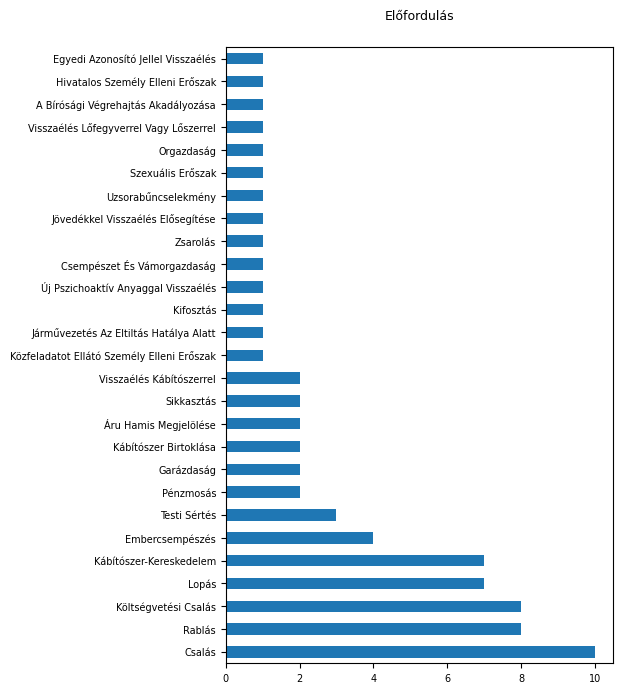

In [18]:
ax = crimes.plot(kind = "barh", figsize = (5, 8), fontsize = 7) 
ax.set_title("Előfordulás", pad = 20, fontsize = 9)

<b>Legtöbb bűncselekmény elkövetésével körözött személy<b>

In [19]:
# bűncselekmények számolása személyenként

count_crimes_person = crimes_person_df["Korozes"].groupby(crimes_person_df.index).count()
person = count_crimes_person.loc[lambda x: x==x.max()]

person_id = person.index.to_list()
most_crimes_per_person_df = df.loc[person_id]
most_crimes_per_person_df["Korozes"].to_frame()

Korozes
Nev           Szuletesi datum                                    
Klement Tibor 1988-03-29                                    Lopás
              1988-03-29       Egyedi Azonosító Jellel Visszaélés
              1988-03-29                    Kábítószer Birtoklása
              1988-03-29                                   Csalás
Matta Elemér  1966-07-10                                 Zsarolás
              1966-07-10                               Garázdaság
              1966-07-10                      Uzsorabűncselekmény
              1966-07-10                             Testi Sértés

<b>Egy vagy több bűncselekményt elkövetett személyek aránya<b>

In [20]:
# maszk azoknak a személyeknek a leválogatásához, akiket több bűncselekmény miatt keresnek
filter = count_crimes_person.apply(lambda x: True if x > 1 else False)

num_persons = len(persons)
num_multiple_crime = len(count_crimes_person[filter])
pct_multiple_crime =  num_multiple_crime / num_persons
pct_single_crime = 1 - pct_multiple_crime

pct_crimes = pd.Series({"Egy bűncselekmény": pct_single_crime,
                        "Több bűncselekmény": pct_multiple_crime})


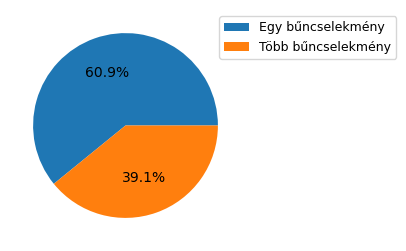

In [21]:
pct_crimes.plot(kind = "pie",autopct="%.1f%%", ylabel="", labels=None, figsize=(3, 3))
plt.legend(labels=pct_crimes.index, loc="upper right", bbox_to_anchor=(1.7, 1.0), fontsize=9)

<b>Nők és férfiak aránya<b>

<AxesSubplot:>

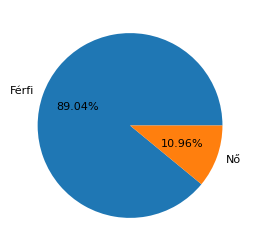

In [22]:
gender_pct = crimes_person_df.groupby("Nem").size()/len(crimes_person_df)

gender_pct.plot(kind ="pie", autopct = "%.2f%%", ylabel = "",figsize=(3, 3), fontsize=8)


<b>Körözött bűnözők életkora<b>

In [23]:
df["Eletkor"] = (pd.to_datetime("today") - df.index.get_level_values(1)).astype("timedelta64[Y]").astype(int)

In [24]:
min_age = df["Eletkor"].min()
max_age = df["Eletkor"].max()
print(f"A toplistán a legfiatalabb körözött {min_age}, míg a legidősebb {max_age} éves.")

A toplistán a legfiatalabb körözött 27, míg a legidősebb 67 éves.


In [25]:
age = df["Eletkor"].astype(int).value_counts().sort_index(ascending = True)
most_common_age = age.loc[lambda x: x==x.max()].index[0]
print(f" A keresett személyek közül a legtöbben {most_common_age} évesek.")

 A keresett személyek közül a legtöbben 43 évesek.


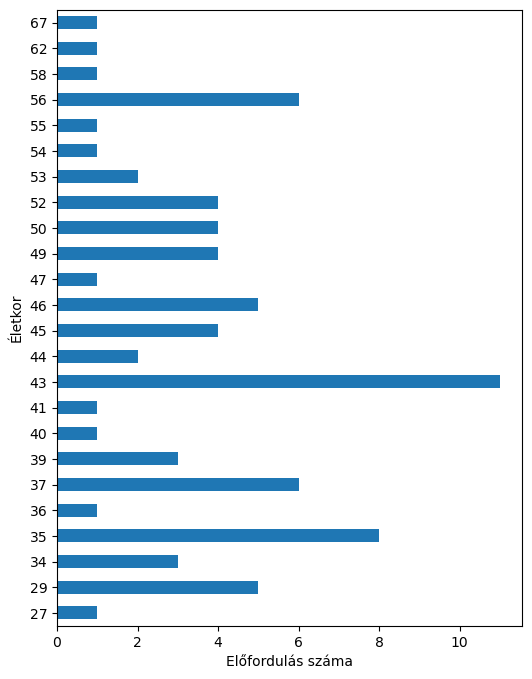

In [26]:
age.plot(kind = "barh", figsize=(6,8))
plt.xlabel("Előfordulás száma")
plt.ylabel("Életkor")
plt.show()

<b>Díjkitűzés összegei és előfordulásai<b>

In [27]:
has_reward_df = df[df["Nyomravezetoi dij"] > 0]
has_reward_df = has_reward_df.loc[:, has_reward_df.columns != "Korozes"].drop_duplicates()
# egy személy több sorban is megjelenik, ha több bűncselekmények miatt is körözik, emiatt a Körözés oszlop nélkül 
# számolom, hogy egyes nyomravezetői díjat mennyi bűnőző után fizetne a rendőrség

has_reward_df["Nyomravezetoi dij"].value_counts().sort_index().to_frame()

,Nyomravezetoi dij
100000,1
200000,2
300000,1
500000,1


<b>Elkövető, akire a legmagasabb nyomravezetői díjat tűzték ki<b>

In [28]:
df[df["Nyomravezetoi dij"] == df["Nyomravezetoi dij"].max()]

,,Nem,Szuletesi hely,Allampolgarsag,Korozes,Nyomravezetoi dij,Jelzo,Eletkor
Nev,Szuletesi datum,,,,,,,
Bartos Nándor,1982-08-14,Férfi,Baja,Magyar,Embercsempészés,500000,,40


<b>Bűnőzökre adott jelzők<b>

In [29]:
traits = df["Jelzo"].unique().tolist()
traits.remove("")
for trait in traits:
    print(trait)

Különösen Veszélyes
Fegyveres


<b>Bűnözők, akiket különösen veszélyes és/vagy fegyveres elkövetőként soroltak be<b>

In [30]:
df[df["Jelzo"].isin(traits)]

Nem Szuletesi hely Allampolgarsag Korozes  \
Nev         Szuletesi datum                                                
Kozák Ali   1985-12-24       Férfi        Miskolc         Magyar           
            1985-12-24       Férfi        Miskolc         Magyar           
Sütő Ferenc 1979-11-27       Férfi    Budapest 03         Magyar           
            1979-11-27       Férfi    Budapest 03         Magyar           

                             Nyomravezetoi dij                Jelzo  Eletkor  
Nev         Szuletesi datum                                                   
Kozák Ali   1985-12-24                       0  Különösen Veszélyes       37  
            1985-12-24                       0            Fegyveres       37  
Sütő Ferenc 1979-11-27                       0  Különösen Veszélyes       43  
            1979-11-27                       0            Fegyveres       43